In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split
import copy


In [41]:
def standard_scalar_normalize(data_train, data_test): 
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    return normal_data_train,normal_data_test

In [42]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train=pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test=pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train=data_train['loan_status']
    data_train.drop(columns=['loan_status', 'id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                               'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                               'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                               'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                               'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                               'WI', 'WV', 'WY'], inplace=True)
    
    data_test.drop(columns=['id', 'issue_d_in_months', 'issue_d_year', 'zip_state_match', 
                           'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
                           'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
                           'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                           'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
                           'WI', 'WV', 'WY'], inplace=True)
    
    normal_data_train,normal_data_test=standard_scalar_normalize(data_train,data_test)
    return normal_data_train,normal_data_test,y_train

def AUC_score(y_ground_truth,y_predicted_probability):
    return roc_auc_score(y_ground_truth, y_predicted_probability)

def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

In [53]:
def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of 
    labels; this is the fraction of samples for which the labels differ.
    
    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """

    return sum(y == real_y) / len(y)
    

def eval_tree_based_model_min_samples(clf, min_samples_leaf, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    minimum leaf size parameters in the vector min_samples_leaf, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        min_samples_leaf: a (T, ) vector of all the min_samples_leaf stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
        train_auc: (T, ) vector of area under the ROC curve (AUC) on the training data
        test_auc: (T, ) vector of area under the ROC curve (AUC) on the testing data
    """
    
    train_err = []
    test_err = []
    train_auc = []
    test_auc = []
    for min_samp in min_samples_leaf: 
        print(min_samp)
        clf.min_child_samples = min_samp
        clf.fit(X_train, y_train, copy.deepcopy(y_train)*4 + 1)
        train_err.append(1 - clf.score(X_train, y_train))
        test_err.append(1 - clf.score(X_test, y_test))
        
        Y_train_pred_prob=clf.predict_proba(X_train)[:,1]
        train_auc.append(AUC_score(y_train,Y_train_pred_prob))
        
        Y_test_pred_prob=clf.predict_proba(X_test)[:,1]
        test_auc.append(AUC_score(y_test,Y_test_pred_prob))

    return train_err, test_err, train_auc, test_auc


In [54]:
def eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    maximum tree depth parameters in the vector max_depth, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        max_depth: a (T, ) vector of all the max_depth stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
        train_auc: (T, ) vector of area under the ROC curve (AUC) on the training data
        test_auc: (T, ) vector of area under the ROC curve (AUC) on the testing data
    """
    train_err = []
    test_err = []
    train_auc = []
    test_auc = []
    for max_dep in max_depth: 
        print(max_dep)
        clf.max_depth = max_dep
        clf.fit(X_train, y_train, copy.deepcopy(y_train)*4 + 1)
        train_err.append(1 - clf.score(X_train, y_train))
        test_err.append(1 - clf.score(X_test, y_test))
        
        Y_train_pred_prob=clf.predict_proba(X_train)[:,1]
        train_auc.append(AUC_score(y_train,Y_train_pred_prob))
        
        Y_test_pred_prob=clf.predict_proba(X_test)[:,1]
        test_auc.append(AUC_score(y_test,Y_test_pred_prob))
        
    return train_err, test_err, train_auc, test_auc


In [55]:
def eval_tree_based_model_n_estimators(clf, n_estimators, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    maximum tree depth parameters in the vector max_depth, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        max_depth: a (T, ) vector of all the max_depth stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
        train_auc: (T, ) vector of area under the ROC curve (AUC) on the training data
        test_auc: (T, ) vector of area under the ROC curve (AUC) on the testing data
    """
    train_err = []
    test_err = []
    train_auc = []
    test_auc = []
    for n_estimator in n_estimators: 
        print(n_estimator)
        clf.n_estimators = n_estimator
        clf.fit(X_train, y_train, copy.deepcopy(y_train)*4 + 1)
        train_err.append(1 - clf.score(X_train, y_train))
        test_err.append(1 - clf.score(X_test, y_test))
        
        Y_train_pred_prob=clf.predict_proba(X_train)[:,1]
        train_auc.append(AUC_score(y_train,Y_train_pred_prob))
        
        Y_test_pred_prob=clf.predict_proba(X_test)[:,1]
        test_auc.append(AUC_score(y_test,Y_test_pred_prob))
        
    return train_err, test_err, train_auc, test_auc


In [102]:
X_train_full,X_test,Y_train_full=data_processed()
X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, train_size=0.80, random_state=42)

In [47]:
sum(Y_train) / len(Y_train)

0.15286438529784538

In [28]:
sum(Y_val) / len(Y_val)

0.1546768060836502

# Sweep min leaf samples 

In [60]:
# Seed the random number generator:
np.random.seed(1)

n_estimators = 100
clf = LGBMClassifier(n_estimators = n_estimators)

min_samples_leaf = np.arange(2, 80, 10)

train_err, test_err, train_auc, test_auc = eval_tree_based_model_min_samples(clf, min_samples_leaf, X_train, 
                                                        Y_train, X_val, Y_val)



2
12
22
32
42
52
62
72


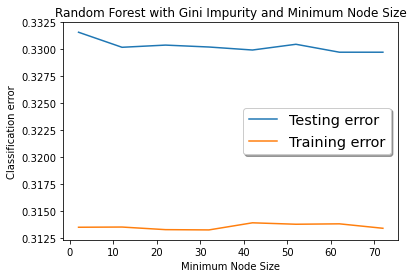

Test error minimized at min_samples_leaf = 62


In [61]:
# Plot testing vs train error
plt.figure()
plt.plot(min_samples_leaf, test_err, label='Testing error')
plt.plot(min_samples_leaf, train_err, label='Training error')
plt.xlabel('Minimum Node Size')
plt.ylabel('Classification error')
plt.title('Random Forest with Gini Impurity and Minimum Node Size')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at min_samples_leaf = %i' % min_samples_leaf[np.argmin(test_err)])

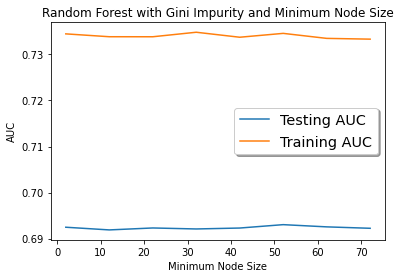

Test auc maximized at min_samples_leaf = 52
max auc: 0.6930291625470437


In [62]:
# Plot AUC
plt.figure()
plt.plot(min_samples_leaf, test_auc, label='Testing AUC')
plt.plot(min_samples_leaf, train_auc, label='Training AUC')
plt.xlabel('Minimum Node Size')
plt.ylabel('AUC')
plt.title('Random Forest with Gini Impurity and Minimum Node Size')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test auc maximized at min_samples_leaf = %i' % min_samples_leaf[np.argmax(test_auc)])
print('max auc:', np.max(test_auc))

## Max depth regularization 

In [63]:
np.random.seed(1)

n_estimators = 100
clf = LGBMClassifier(n_estimators = n_estimators)

max_depth = np.arange(10, 40, 3)

train_err, test_err, train_auc, test_auc = eval_tree_based_model_max_depth(clf, max_depth, X_train, 
                                                        Y_train, X_val, Y_val)

10
13
16
19
22
25
28
31
34
37


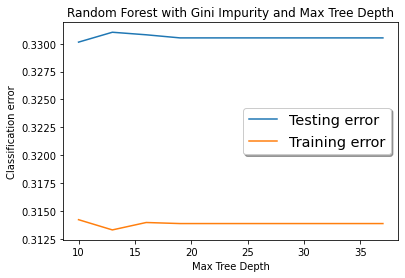

Test error minimized at max_tree_depth = 10


In [64]:
# Plot testing vs train error
plt.figure()
plt.plot(max_depth, test_err, label='Testing error')
plt.plot(max_depth, train_err, label='Training error')
plt.xlabel('Max Tree Depth')
plt.ylabel('Classification error')
plt.title('Random Forest with Gini Impurity and Max Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at max_tree_depth = %i' % max_depth[np.argmin(test_err)])

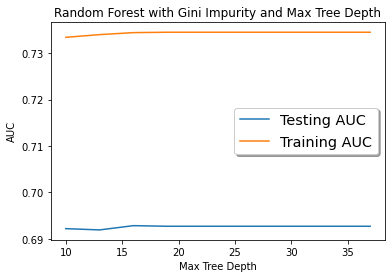

Test auc maximized at max_tree_depth = 16
max auc: 0.692832036892951


In [65]:
# Plot AUC
plt.figure()
plt.plot(max_depth, test_auc, label='Testing AUC')
plt.plot(max_depth, train_auc, label='Training AUC')
plt.xlabel('Max Tree Depth')
plt.ylabel('AUC')
plt.title('Random Forest with Gini Impurity and Max Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test auc maximized at max_tree_depth = %i' % max_depth[np.argmax(test_auc)])
print('max auc:', np.max(test_auc))

## Performance across # estimators

In [66]:
np.random.seed(1)

clf = LGBMClassifier()

n_estimators = np.arange(20, 300, 25)

train_err, test_err, train_auc, test_auc = eval_tree_based_model_n_estimators(clf, n_estimators, X_train, 
                                                        Y_train, X_val, Y_val)

20
45
70
95
120
145
170
195
220
245
270
295


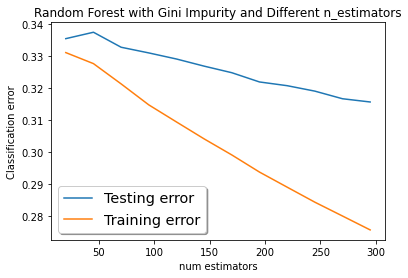

Test error minimized at n_estimators = 295


In [67]:
# Plot testing vs train error
plt.figure()
plt.plot(n_estimators, test_err, label='Testing error')
plt.plot(n_estimators, train_err, label='Training error')
plt.xlabel('num estimators')
plt.ylabel('Classification error')
plt.title('Random Forest with Gini Impurity and Different n_estimators')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at n_estimators = %i' % n_estimators[np.argmin(test_err)])

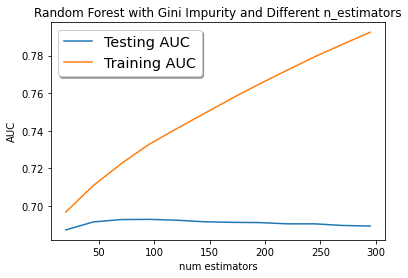

Test auc maximized at n_estimators = 95
max auc: 0.6928868996756472


In [68]:
# Plot AUC
plt.figure()
plt.plot(n_estimators, test_auc, label='Testing AUC')
plt.plot(n_estimators, train_auc, label='Training AUC')
plt.xlabel('num estimators')
plt.ylabel('AUC')
plt.title('Random Forest with Gini Impurity and Different n_estimators')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test auc maximized at n_estimators = %i' % n_estimators[np.argmax(test_auc)])
print('max auc:', np.max(test_auc))

## Grid search

In [73]:
parameters = {'n_estimators': np.arange(80, 150, 20), 'min_child_samples': np.arange(30, 80, 5), 'max_depth':  np.arange(5, 30, 3)}
rfc = LGBMClassifier(class_weight='balanced')
clf = GridSearchCV(rfc, parameters, scoring='roc_auc', verbose=2.1, n_jobs=1)
clf.fit(X_train, Y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] max_depth=5, min_child_samples=30, n_estimators=80 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_child_samples=30, n_estimators=80, score=0.688, total=   1.0s
[CV] max_depth=5, min_child_samples=30, n_estimators=80 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=5, min_child_samples=30, n_estimators=80, score=0.696, total=   0.8s
[CV] max_depth=5, min_child_samples=30, n_estimators=80 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=5, min_child_samples=30, n_estimators=80, score=0.693, total=   0.8s
[CV] max_depth=5, min_child_samples=30, n_estimators=80 ..............
[CV]  max_depth=5, min_child_samples=30, n_estimators=80, score=0.688, total=   0.8s
[CV] max_depth=5, min_child_samples=30, n_estimators=80 ..............
[CV]  max_depth=5, min_child_samples=30, n_estimators=80, score=0.691, total=   0.8s
[CV] max_depth=5, min_child_samples=30, n_estimators=100 .............
[CV]  max_depth=5, min_child_samples=30, n_estimators=100, score=0.689, total=   1.0s
[CV] max_depth=5, min_child_samples=30, n_estimators=100 .............
[CV]  max_depth=5, min_child_samples=30, n_estimators=100, score=0.696, total=   0.9s
[CV] max_depth=5, min_child_samples=30, n_estimators=100 .............
[CV]  max_depth=5, min_child_samples=30, n_estimators=100, score=0.694, total=   0.9s
[CV] max_depth=5, min_child_samples=30, n_estimators=100 .............
[CV]  max_depth=5, min_child_samples=30, n_estimators=100, sc

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 40.5min finished


GridSearchCV(estimator=LGBMClassifier(class_weight='balanced'), n_jobs=1,
             param_grid={'max_depth': array([ 5,  8, 11, 14, 17, 20, 23, 26, 29]),
                         'min_child_samples': array([30, 35, 40, 45, 50, 55, 60, 65, 70, 75]),
                         'n_estimators': array([ 80, 100, 120, 140])},
             scoring='roc_auc', verbose=2.1)

In [76]:
results_df = pd.DataFrame(clf.cv_results_)

In [77]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_child_samples', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [79]:
results_sub_df = results_df.loc[:, ['param_max_depth', 'param_min_child_samples', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']]

In [82]:
results_sub_df.sort_values('rank_test_score').head(20)

,param_max_depth,param_min_child_samples,param_n_estimators,mean_test_score,std_test_score,rank_test_score
104,11,60,80,0.692220,0.003640,1
39,5,75,140,0.692197,0.003683,2
38,5,75,120,0.692167,0.003608,3
105,11,60,100,0.692082,0.003562,4
109,11,65,100,0.691998,0.003546,5
27,5,60,140,0.691983,0.003623,6
149,14,65,100,0.691973,0.003517,7
26,5,60,120,0.691969,0.003516,8
106,11,60,120,0.691953,0.003657,9
69,8,65,100,0.691950,0.003560,10


In [95]:
Y_val_pred_prob=clf.best_estimator_.predict_proba(X_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

0.6922932719829431

In [96]:
Y_train_pred_prob=clf.best_estimator_.predict_proba(X_train)[:,1]
AUC_score(Y_train,Y_train_pred_prob)

0.7261211832540153

In [97]:
Y_val_pred=clf.best_estimator_.predict(X_val)
confusion_matrix(Y_val,Y_val_pred)

array([[20981, 12367],
       [ 2142,  3960]])

In [98]:
Y_train_pred=clf.best_estimator_.predict(X_train)
confusion_matrix(Y_train,Y_train_pred)

array([[85281, 48397],
       [ 7475, 16647]])

In [101]:
clf.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 11,
 'min_child_samples': 60,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 80,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

## retrain on full data

In [103]:
clf.best_estimator_.fit(X_train_full, Y_train_full)

LGBMClassifier(class_weight='balanced', max_depth=11, min_child_samples=60,
               n_estimators=80)

In [105]:
Y_val_pred_prob=clf.best_estimator_.predict_proba(X_val)[:,1]
AUC_score(Y_val,Y_val_pred_prob)

0.7209763692176032

In [107]:
Y_train_pred_prob=clf.best_estimator_.predict_proba(X_train)[:,1]
AUC_score(Y_train,Y_train_pred_prob)

0.7199505884534975

In [104]:
Y_val_pred=clf.best_estimator_.predict(X_val)
confusion_matrix(Y_val,Y_val_pred)

array([[21065, 12283],
       [ 1887,  4215]])

In [106]:
Y_train_pred=clf.best_estimator_.predict(X_train)
confusion_matrix(Y_train,Y_train_pred)

array([[84555, 49123],
       [ 7559, 16563]])

## Output for submissions - evaluate on test set 

In [108]:
Y_test_pred_prob=clf.best_estimator_.predict_proba(X_test)[:,1]

In [109]:
def to_submission(ids, y_test_predicted_probability):
    y_test=pd.DataFrame(y_test_predicted_probability,columns=['loan_status'], index=ids)
    y_test.index.name = 'id'
    y_test.to_csv('data/submission.csv')
    return

to_submission(pd.read_csv("data/2022-02-07_LOANS_TEST.csv")['id'].values, Y_test_pred_prob)